In [2]:
# Display tools
from IPython.display import HTML, display  # For HTML rendering in notebooks
import os 
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
import os

def get_dicom_paths(directory_path, label=None, verbose=True):
    """
    Scans a directory for DICOM (.dcm) files and returns their paths.

    Parameters:
    - directory_path (str): Directory to scan for .dcm files
    - label (str, optional): Label for display (e.g., 'train', 'test')
    - verbose (bool): Whether to print the number of files found

    Returns:
    - List[str]: Paths to DICOM files
    """
    dicom_paths = [
        os.path.join(directory_path, file)
        for file in os.listdir(directory_path)
        if file.lower().endswith('.dcm')
    ]
    
    if verbose:
        label_text = f" in the '{label}' directory" if label else ""
        print(f" Found {len(dicom_paths)} DICOM files{label_text}.")
    
    return dicom_paths

# --- Define Image Directories ---
TRAIN_IMG_DIR = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_images"
TEST_IMG_DIR  = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_test_images"

# --- Get File Paths ---
train_img_paths = get_dicom_paths(TRAIN_IMG_DIR, label="train")
test_img_paths  = get_dicom_paths(TEST_IMG_DIR, label="test")


 Found 26684 DICOM files in the 'train' directory.
 Found 3000 DICOM files in the 'test' directory.


In [5]:
# --- Define Image Directories ---
TRAIN_IMG_DIR = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_images"
TEST_IMG_DIR  = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_test_images"

train_img_path = get_dicom_paths(TRAIN_IMG_DIR, label="train")
test_img_path  = get_dicom_paths(TEST_IMG_DIR, label="test")


 Found 26684 DICOM files in the 'train' directory.
 Found 3000 DICOM files in the 'test' directory.


In [6]:
labels = pd.read_csv(r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_labels.csv")
labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [7]:
count_normal = len(labels.loc[labels['Target']==0])
count_pnemonia= len(labels.loc[labels['Target']==1])
traing_count=len(train_img_path)

In [8]:
weight_for_zero =(1/count_normal)*(traing_count)/2.0
weight_for_ones =(1/count_pnemonia)*(traing_count)/2.0

In [9]:
classweight= {0: weight_for_zero,
              1: weight_for_ones}

In [10]:
print("Weights:", classweight)

Weights: {0: 0.6454140866873065, 1: 1.3963369963369963}


In [11]:
def parseMetadata(dcm):  # corrected from 'paraseMetadata'
    unpackedData = {}
    groupElemToKeywords = {}
    
    for d in dcm:  # This forces conversion from lazy RawDataElement to DataElement
        pass

    # Un-pack Data
    for tag, elem in dcm.items():
        tagGroup = tag.group
        tagElem = tag.elem
        keyword = elem.keyword
        groupElemToKeywords[(tagGroup, tagElem)] = keyword
        value = elem.value
        unpackedData[keyword] = value
        
    return unpackedData, groupElemToKeywords


In [12]:
from tqdm import tqdm

In [14]:
import pydicom
from tqdm import tqdm

# Step 1: Read DICOM files from paths
train_dcms = [pydicom.dcmread(path) for path in tqdm(train_img_path)]
test_dcms = [pydicom.dcmread(path) for path in tqdm(test_img_path)]

# Step 2: Parse metadata from DICOM datasets
trainMetaDicts, trainKeyword = zip(*[parseMetadata(dcm) for dcm in tqdm(train_dcms)])
testMetaDicts, testKeyword = zip(*[parseMetadata(dcm) for dcm in tqdm(test_dcms)])


100%|██████████| 3000/3000 [00:03<00:00, 867.20it/s] 


In [15]:
def createY(df):
    """
    Returns binary labels: 1 if 'SeriesDescription' is 'view: PA', else 0.
    """
    if 'SeriesDescription' not in df.columns:
        raise ValueError("Missing 'SeriesDescription' column in DataFrame.")
    
    return (df['SeriesDescription'] == 'view: PA').astype(int).values


In [16]:
train_df = pd.DataFrame.from_dict(data=trainMetaDicts)
test_df = pd.DataFrame.from_dict(data=testMetaDicts)

train_df['dataset'] = 'train'
test_df['dataset'] = 'test'

train_Y = createY(train_df)
test_Y = createY(test_df)


In [17]:
test_Y

array([1, 1, 1, ..., 1, 1, 1], shape=(3000,))

In [18]:
def decodeImage(filePath):
    image = pydicom.dcmread(filePath).pixel_array
    image = cv2.resize(image, (128, 128))
    return image / 255.0


In [20]:

import cv2
import numpy as np

# Get our train x in the correct shape
train_X = []

for filePath in tqdm(train_img_path[:5000]):
    
    img = decodeImage(filePath)
    train_X.append(img)

train_X = np.array(train_X) # Convert to np.array
train_X_rgb = np.repeat(train_X[..., np.newaxis], 3, -1) # Reshape into rgb format

100%|██████████| 5000/5000 [00:47<00:00, 105.47it/s]


In [21]:
test_X =[]
for filePath in tqdm(test_img_path[:5000]):
    
    img = decodeImage(filePath)
    test_X.append(img)

test_X = np.array(test_X) # Convert to np array
test_X_rgb = np.repeat(test_X[..., np.newaxis], 3, -1) # Reshape into rgb format

100%|██████████| 3000/3000 [00:30<00:00, 99.31it/s] 


In [25]:
import matplotlib.pyplot as plt

def plot_score(hist):
    fig, ax = plt.subplots(1, 5, figsize=(20, 3))  # Corrected 'subplot' to 'subplots'
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'precision', 'recall', 'AUC', 'loss']):
        ax[i].plot(hist.history[met])
        ax[i].plot(hist.history['val_' + met])
        ax[i].set_title(f'Model {met}')
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()


In [27]:
!pip install tensorflow

  Using cached tensorflow-2.19.0-cp311-cp311-win_amd64.whl.metadata (4.1 kB)
  Using cached absl_py-2.3.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-5.29.5-cp310-abi3-win_amd64.whl.metadata (592 bytes)
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached wrapt-1.17.2-cp311-cp311-win_amd64.whl.metadata (6.5 kB)
  Using cached grpcio-1.73.0-cp311-cp311-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cach

  You can safely remove it manually.
  You can safely remove it manually.


In [28]:
import tensorflow as tf

In [36]:
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import Model


In [30]:
# These our our scoring metrics that are going to be used to evaluate our models
METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'), 
           tf.keras.metrics.AUC(name='AUC')]

In [32]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

Baseline Model CNN

In [38]:
import tensorflow as tf

def build_fcnn_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(128, 128, 3)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model


In [39]:
model_fcnn=build_fcnn_model()


c:\Users\samya\PyCharmProject\Pneumonia-Detection\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [40]:
model_fcnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,291,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,291,713 (24.00 MB)

 Trainable params: 6,291,713 (24.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_fcnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=METRICS)

In [49]:
history_fcnn = model_fcnn.fit(train_X_rgb, 
                          train_Y,  
                          epochs = 100,
                          batch_size = 128,
                          validation_split = 0.2, 
                          class_weight = classweight, 
                          verbose = 1,
                          callbacks = [checkpoint_cb, early_stopping_cb, lr_scheduler]) # Fit the model

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - AUC: 0.6962 - accuracy: 0.6937 - loss: 8.8013 - precision: 0.6898 - recall: 0.8239 - val_AUC: 0.7179 - val_accuracy: 0.6490 - val_loss: 3.6950 - val_precision: 0.6037 - val_recall: 0.9906 - learning_rate: 0.0100
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - AUC: 0.8479 - accuracy: 0.7924 - loss: 1.0619 - precision: 0.7676 - recall: 0.9081 - val_AUC: 0.9492 - val_accuracy: 0.8440 - val_loss: 0.3633 - val_precision: 0.7928 - val_recall: 0.9568 - learning_rate: 0.0089
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - AUC: 0.9470 - accuracy: 0.8641 - loss: 0.2803 - precision: 0.8372 - recall: 0.9323 - val_AUC: 0.9565 - val_accuracy: 0.8690 - val_loss: 0.3167 - val_precision: 0.8250 - val_recall: 0.9568 - learning_rate: 0.0079
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - AUC: 0.9610 - accuracy: 0.8890 - loss: 0.2422 - precision: 0.8726 - recall: 0.9320 - val_AUC: 0.9612 - val_accuracy: 0.8480 - val_loss: 0.3584 -

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - AUC: 0.9721 - accuracy: 0.8974 - loss: 0.2084 - precision: 0.8682 - recall: 0.9578 - val_AUC: 0.9691 - val_accuracy: 0.9020 - val_loss: 0.2362 - val_precision: 0.8820 - val_recall: 0.9417 - learning_rate: 0.0040
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - AUC: 0.9731 - accuracy: 0.9067 - loss: 0.2037 - precision: 0.8788 - recall: 0.9605 - val_AUC: 0.9700 - val_accuracy: 0.8900 - val_loss: 0.2479 - val_precision: 0.8540 - val_recall: 0.9568 - learning_rate: 0.0035
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - AUC: 0.9721 - accuracy: 0.9021 - loss: 0.2084 - precision: 0.8757 - recall: 0.9559 - val_AUC: 0.9708 - val_accuracy: 0.8980 - val_loss: 0.2429 - val_precision: 0.8656 - val_recall: 0.9568 - learning_rate: 0.0032
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - AUC: 0.9765 - accuracy: 0.9053 - loss: 0.1923 - precision: 0.8813 - recall: 0.9572 - val_AUC: 0.9714 - val_accuracy: 0.8820 - val_loss: 0.2812 - val_prec

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.9657 - accuracy: 0.8960 - loss: 0.2468 - precision: 0.8794 - recall: 0.9324
{'loss': 0.24514074623584747, 'compile_metrics': 0.8986666798591614}


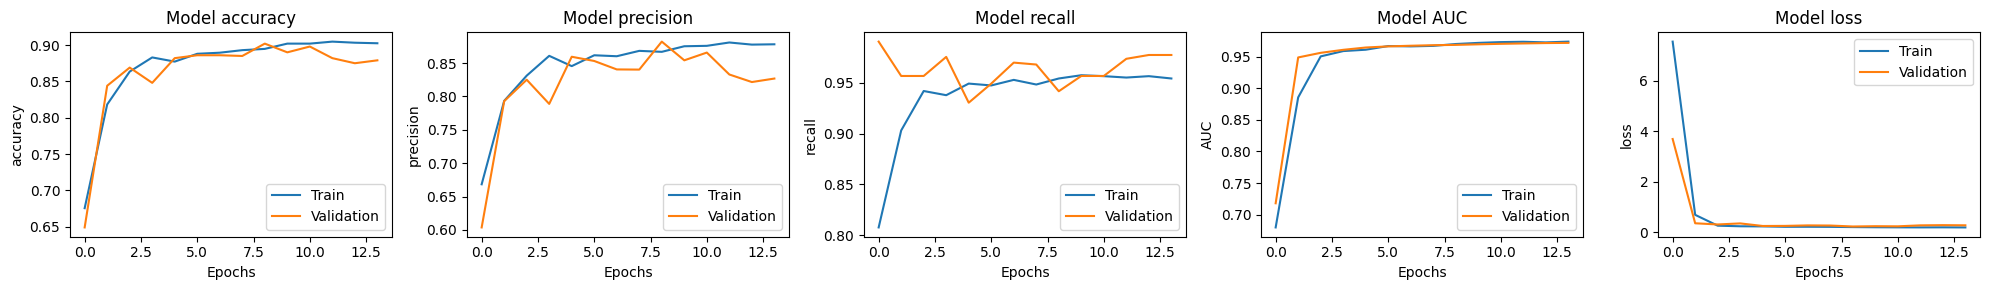

In [50]:
# Evaluate and display results
results = model_fcnn.evaluate(test_X_rgb, test_Y) # Evaluate the model on test data
results = dict(zip(model_fcnn.metrics_names,results))

print(results)
plot_score(history_fcnn) # Visualise scores